# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
from datetime import datetime
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from copy import deepcopy as dc

# own classes
from utilities import reconstruct_sequential_data, train_test_split, extract_features_and_targets_reg, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model, LSTMClassification
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [3]:
DATA_FOLDER = Path("../data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"
LOAD_ORIGINAL_DATA = False

### Hyperparams (ish)

In [4]:
BENCHMARK = False
RANDOM_LABEL_PERMUTATION = False
CLASSIFICATION = False


NUM_EPOCHS = 100
SEQ_LEN = 12
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

LEARNING_RATE = 0.0001
BATCH_SIZE = 32
HIDDEN_SIZE = 4
NUM_LAYERS = 1

OUTPUT_LOGITS = True
BIDIRECTIONAL = True


### Features

In [5]:
USE_LABEL_ENCODING = True
NO_FEATURES_TO_SCALE = 10 if CLASSIFICATION else 9 # classification includes trend as first feature

FEATURES = ["traffic_volume", "temp", "rain_1h", "snow_1h", "clouds_all", "month", "hour", "weather_main", "weather_description", "weekend", "holiday"]

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [7]:
if LOAD_ORIGINAL_DATA:
    print('Loading original data, include only data from 2015-07-01 and reindex to full range with hourly frequency')
    # load and convert date column to datetime
    traffic = pd.read_csv(REAL_DATA_FOLDER / 'metro_interstate_traffic_volume_original.csv')
    traffic['date'] = pd.to_datetime(traffic['date'])

    # create a series with a full range of dates with hourly frequency
    # does take leap years and different month length into account
    full_range = pd.date_range(start=traffic['date'].min(), end=traffic['date'].max(), freq='H')

    traffic = traffic.drop_duplicates(subset='date') # drop duplicates
    traffic.set_index('date', inplace=True) # set date as index

    traffic = traffic.reindex(full_range, method='nearest') # reindex to full_range and fill missing values with nearest value

    # set index name and reset index to keep date as column
    traffic.index.name = 'date'
    traffic.reset_index(inplace=True)

    # only include data from 2015-07-01
    # the reason is because the data before that date is not complete
    traffic = traffic[traffic['date'] > '2015-07-01']

else:
    print('Loading label encoded data')
    traffic = pd.read_csv(REAL_DATA_FOLDER / 'metro_interstate_traffic_volume_label_encoded.csv')


Loading label encoded data


In [8]:
traffic.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
0,444,289.40,0.0,0.0,1,7,1,0,24,0,0
1,347,289.19,0.0,0.0,1,7,2,0,24,0,0
2,356,288.74,0.3,0.0,1,7,3,6,12,0,0
3,936,288.07,0.0,0.0,1,7,4,0,24,0,0
4,2886,287.87,0.0,0.0,1,7,5,0,24,0,0


## Feature Engineering (only if original data is loaded)

In [9]:
if LOAD_ORIGINAL_DATA:
    # new columns for month and hour
    traffic['month'] = traffic['date'].dt.month
    traffic['hour'] = traffic['date'].dt.hour

    # encode holiday and weekend as binary variable
    traffic['holiday'] = traffic['holiday'].apply(lambda x: 0 if pd.isna(x) else 1)
    traffic['weekend'] = traffic['date'].apply(lambda x: 1 if x.day_of_week in [5, 6] else 0)

    # encode categorical variables
    if USE_LABEL_ENCODING:
        print('Using label encoding')
        # use label encoding for categorical variables
        # NOTE: hours and months are kept as is since they are "label encoded" by default
        traffic['weather_main'] = traffic['weather_main'].astype('category').cat.codes
        traffic['weather_description'] = traffic['weather_description'].astype('category').cat.codes

        # drop unnecessary columns
        traffic.drop(columns=['date'], inplace=True)
    else:
        print('Using One-Hot and cyclic encoding')
        # use one hot encoding for categorical variables
        traffic = pd.get_dummies(traffic, columns=['weather_main', 'weather_description', 'month'], dtype=int)

        # encode hour as cyclic variable
        traffic['hour_sin'] = np.sin((2 * np.pi * traffic['hour']) / 24)
        traffic['hour_cos'] = np.cos((2 * np.pi * traffic['hour']) / 24)
        
        # drop unnecessary columns
        traffic.drop(columns=['date', 'hour'], inplace=True)
else:
    print('Using label encoded data and skipped feature engineering') 

Using label encoded data and skipped feature engineering


In [10]:
if LOAD_ORIGINAL_DATA:
    # extract columns which have to be scaled
    traffic_volume = traffic.pop('traffic_volume')
    temp = traffic.pop('temp')
    clouds_all = traffic.pop('clouds_all')

    # insert so that target is the first column
    traffic.insert(0, 'clouds_all', clouds_all)
    traffic.insert(0, 'temp', temp)
    traffic.insert(0, 'traffic_volume', traffic_volume)

    print('Rearranging first 3 columns to be traffic_volume, temp and clouds_all')

else:
    print('Using label encoded data and skipped rearranging columns')

Using label encoded data and skipped rearranging columns


In [11]:
if LOAD_ORIGINAL_DATA:
    if CLASSIFICATION:
        traffic['traffic_volume_diff'] = traffic['traffic_volume'].diff()
        traffic_volume_diff = traffic.pop('traffic_volume_diff')
        traffic.insert(0, 'traffic_volume_diff', traffic_volume_diff)

        traffic.dropna(inplace=True)

        traffic['traffic_volume_diff'] = traffic['traffic_volume_diff'].apply(lambda x: 1 if x > 0 else 0)
        
        print("Added traffic_volume_diff column as target")

else:
    print('Using label encoded data and skipped adding traffic_volume_diff column as target')

Using label encoded data and skipped adding traffic_volume_diff column as target


## Check Loaded data

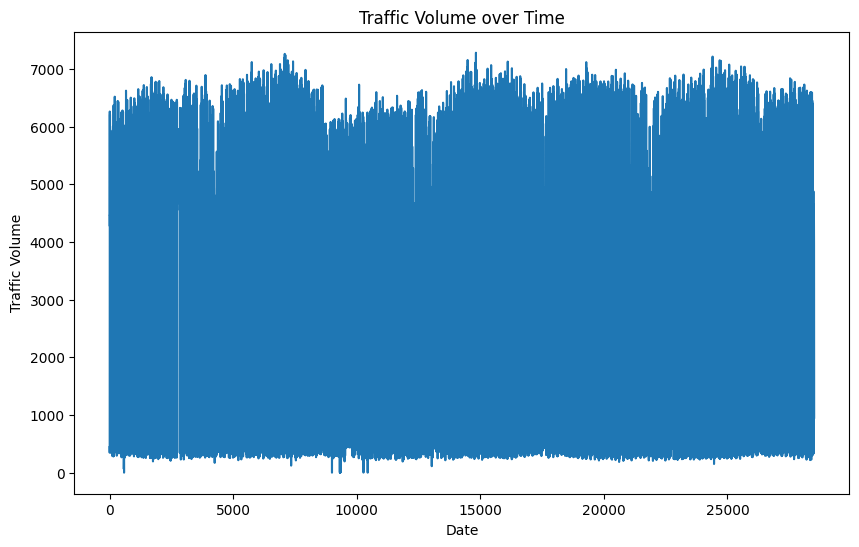

In [12]:
# plot traffic volume
plt.figure(figsize=(10, 6))
plt.plot(traffic['traffic_volume'])
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume over Time')
plt.show()

In [13]:
traffic.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,month,hour,weather_main,weather_description,weekend,holiday
0,444,289.40,0.0,0.0,1,7,1,0,24,0,0
1,347,289.19,0.0,0.0,1,7,2,0,24,0,0
2,356,288.74,0.3,0.0,1,7,3,6,12,0,0
3,936,288.07,0.0,0.0,1,7,4,0,24,0,0
4,2886,287.87,0.0,0.0,1,7,5,0,24,0,0


## Preprocessing

In [14]:
traffic_np = traffic.to_numpy()

In [15]:
traffic_train, traffic_test = train_test_split(traffic_np, FIRST_SPLIT)
traffic_test, traffic_val = train_test_split(traffic_test, SECOND_SPLIT)

In [16]:
traffic_train.shape, traffic_test.shape, traffic_val.shape

((22808, 11), (2851, 11), (2852, 11))

In [17]:
scaler = Scaler(traffic_train, no_features_to_scale=NO_FEATURES_TO_SCALE)

In [18]:
traffic_train_scaled = scaler.scale_data(traffic_train)
traffic_test_scaled = scaler.scale_data(traffic_test)
traffic_val_scaled = scaler.scale_data(traffic_val)

In [19]:
traffic_train_scaled[0]

array([0.06098901, 0.71958086, 0.        , 0.        , 0.01      ,
       0.54545455, 0.04347826, 0.        , 0.72727273, 0.        ,
       0.        ])

In [20]:
traffic_train_seq_scaled = split_data_into_sequences(traffic_train_scaled, SEQ_LEN)
traffic_test_seq_scaled = split_data_into_sequences(traffic_test_scaled, SEQ_LEN)
traffic_val_seq_scaled = split_data_into_sequences(traffic_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (22797, 12, 11)
Shape of the data after splitting into sequences: (2840, 12, 11)
Shape of the data after splitting into sequences: (2841, 12, 11)


In [21]:
if CLASSIFICATION:
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.MSELoss()

### Benchmarking methods

In [22]:
def create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val):
    # get baseline performance
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

    test_dataset = TimeSeriesDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_dataset = TimeSeriesDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader, val_loader

In [23]:
def train_model_once(no_features, train_loader, val_loader):
    # create and train model
    model = LSTMClassification(
        device=device,
        batch_size = BATCH_SIZE,
        input_size=no_features,
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        output_logits=OUTPUT_LOGITS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    _, _, _, _, model = train_model(model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                device=device,
                verbose=False)
    
    return model

In [24]:
def get_test_performance(model, X_test, y_test):
    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        test_loss = criterion(test_logits, y_test).item()

    return test_acc, test_loss

## Benchmark / Training

In [25]:
# get train, test and validation data
if CLASSIFICATION:
    print('Classification')
    X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(traffic_train_seq_scaled, traffic_test_seq_scaled, traffic_val_seq_scaled)
else:
    print('Regression')
    X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets_reg(traffic_train_seq_scaled, traffic_test_seq_scaled, traffic_val_seq_scaled)

Regression


In [26]:
if BENCHMARK:
        
    results = pd.DataFrame(columns=['Feature', 'Metric', 'Value'])
    test_accs = []
    test_losses = []

    for i in range(5):
        # get baseline performance
        train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, X_test, y_test, X_val, y_val)
        trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
        test_acc, test_loss = get_test_performance(trained_model, X_test, y_test)

        test_accs.append(test_acc)
        test_losses.append(test_loss)

    # save baseline performance
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
    results = pd.concat([results, pd.DataFrame([{'Feature': 'baseline', 'Metric': 'Loss', 'Value': np.mean(np.array(test_losses))}])], ignore_index=True)

    for feature in FEATURES[1:]:

        print(f'Current feature: {feature}')
        test_accs = []
        test_losses = []

        for i in range(5):
            print(f'Iteration {i+1}')

            # random permutation of one specific feature
            feature_index = FEATURES.index(feature)-1 # -1 because of the trend feature
            permuted_X_test = dc(X_test)
            permuted_X_test[:, :, feature_index] = torch.tensor(np.random.permutation(permuted_X_test[:, :, feature_index]), dtype=torch.float32)

            train_loader, test_loader, val_loader = create_data_loader(X_train, y_train, permuted_X_test, y_test, X_val, y_val)
            trained_model = train_model_once(len(FEATURES)-1, train_loader, val_loader)
            test_acc, test_loss = get_test_performance(trained_model, permuted_X_test, y_test)

            test_accs.append(test_acc)
            test_losses.append(test_loss)

        # save performance
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Accuracy', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)
        results = pd.concat([results, pd.DataFrame([{'Feature': feature, 'Metric': 'Loss', 'Value': np.mean(np.array(test_accs))}])], ignore_index=True)

else:
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)
    val_dataset = TimeSeriesDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    if CLASSIFICATION:
        print('Using BCEWithLogitsLoss for classification')
        criterion = nn.BCEWithLogitsLoss()
    else:
        print('Using MSELoss for regression')
        criterion = nn.MSELoss()
        
    val_losses = []
    val_accs = []
    train_losses = []
    train_accs = []

    model = LSTMClassification(
            device=device,
            batch_size = BATCH_SIZE,
            input_size=X_train.shape[2], # number of features
            hidden_size=HIDDEN_SIZE,
            num_stacked_layers=NUM_LAYERS,
            bidirectional=BIDIRECTIONAL,
            output_logits=OUTPUT_LOGITS
        ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, train_accs, val_losses, val_accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=device,
                        num_epochs=NUM_EPOCHS,
                        verbose=True)

Using MSELoss for regression
Epoch: 1
Training Loss: 0.14238677151501178
Training Loss: 0.09681495598517359
Training Loss: 0.08176990111358463
Validation Loss: 0.06643077084438855
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07017117102630437
Training Loss: 0.06313145742751658
Training Loss: 0.06376442902721464
Validation Loss: 0.05934877429952782
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06422960868105293
Training Loss: 0.05840414809063077
Training Loss: 0.058910083370283244
Validation Loss: 0.054301198006848274
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05920070431195199
Training Loss: 0.05335898076184094
Training Loss: 0.05358076999895275
Validation Loss: 0.048331476622418074
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.05320385698229074
Training Loss: 0

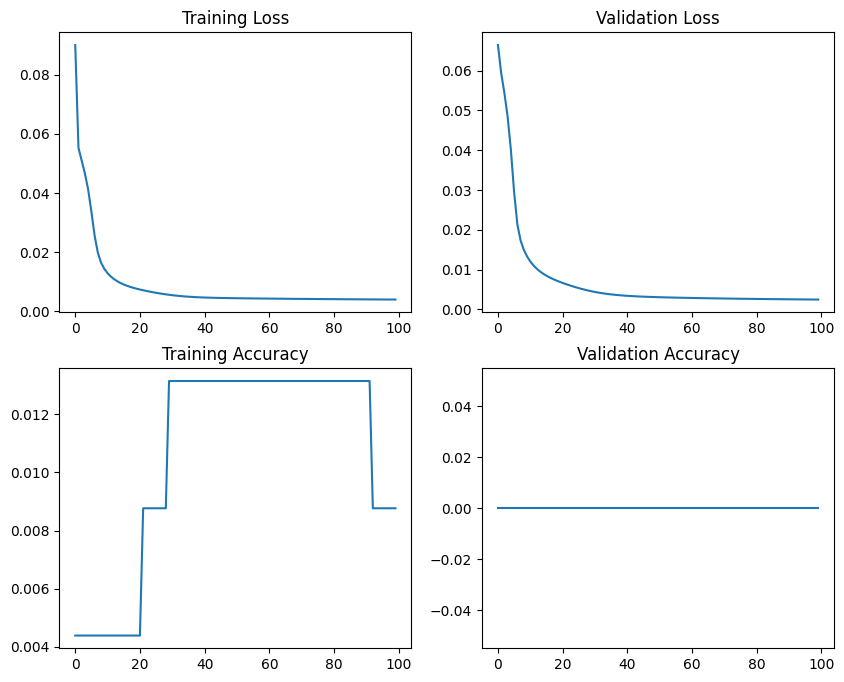

In [27]:
if BENCHMARK:

    # Erstelle eine Pivot-Tabelle, um die Daten besser zu handhaben
    pivot_df = results.pivot(index='Feature', columns='Metric', values='Value')

    # Sortiere die Daten nach den Accuracy-Werten
    pivot_df = pivot_df.sort_values(by='Accuracy', ascending=False)

    # Anzahl der Features
    num_features = len(pivot_df.index)

    # Initialisiere die Hauptfigur und die Hauptachse
    fig, ax1 = plt.subplots(figsize=(10, num_features * 0.4))  # Höhe proportional zur Anzahl der Features

    # Balkenbreite
    bar_height = 0.35

    # Positionen der Balken
    r1 = np.arange(len(pivot_df.index))
    r2 = [x + bar_height for x in r1]

    # Balken für Accuracy
    accuracy_bars = ax1.barh(r1, pivot_df['Accuracy'], color='skyblue', height=bar_height, label='Accuracy')

    # Zweite y-Achse für Loss
    ax2 = ax1.twiny()
    loss_bars = ax2.barh(r2, pivot_df['Loss'], color='salmon', height=bar_height, label='Loss')

    # Titel und Achsenbeschriftungen hinzufügen
    ax1.set_title('Feature Importance: Accuracy and Loss', fontsize=16)
    ax1.set_ylabel('Feature', fontsize=14)
    ax1.set_xlabel('Accuracy', fontsize=14, color='skyblue')
    ax2.set_xlabel('Loss', fontsize=14, color='salmon')

    # y-Ticks setzen
    ax1.set_yticks([r + bar_height/2 for r in range(len(pivot_df.index))])
    ax1.set_yticklabels(pivot_df.index)

    # Achsenbeschriftungen einfärben
    ax1.tick_params(axis='x', labelcolor='skyblue')
    ax2.tick_params(axis='x', labelcolor='salmon')

    # Legenden kombinieren
    bars = accuracy_bars + loss_bars
    labels = [bar.get_label() for bar in bars]
    ax1.legend(bars, labels, loc='lower right')

    # Diagramm anzeigen
    plt.tight_layout()
    plt.show()

else:
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
    axs[0, 0].plot(train_losses, label="MSELoss")
    axs[0, 0].set_title('Training Loss')

    axs[0, 1].plot(val_losses, label="MSELoss")
    axs[0, 1].set_title('Validation Loss')

    axs[1, 0].plot(train_accs, label="Accuracy")
    axs[1, 0].set_title('Training Accuracy')

    axs[1, 1].plot(val_accs, label="Accuracy")
    axs[1, 1].set_title('Validation Accuracy')

In [28]:
if CLASSIFICATION:
    acc, loss = get_test_performance(model, X_test, y_test)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {acc}')

else:
    dummy_regressor = MeanRegressor()

    with torch.inference_mode(): 
        test_preds = model(X_test.to(device)) # get plain model output
        test_loss = criterion(test_preds, y_test).item()
        print(f'Test Loss: {test_loss}')

        dummy_preds = torch.tensor(dummy_regressor.make_predictions(X_test)).reshape(-1, 1)
        dummy_loss = criterion(dummy_preds, y_test).item()
        print(f'Dummy Loss: {dummy_loss}')


Test Loss: 0.0031359645072370768
Dummy Loss: 0.026615221331152312


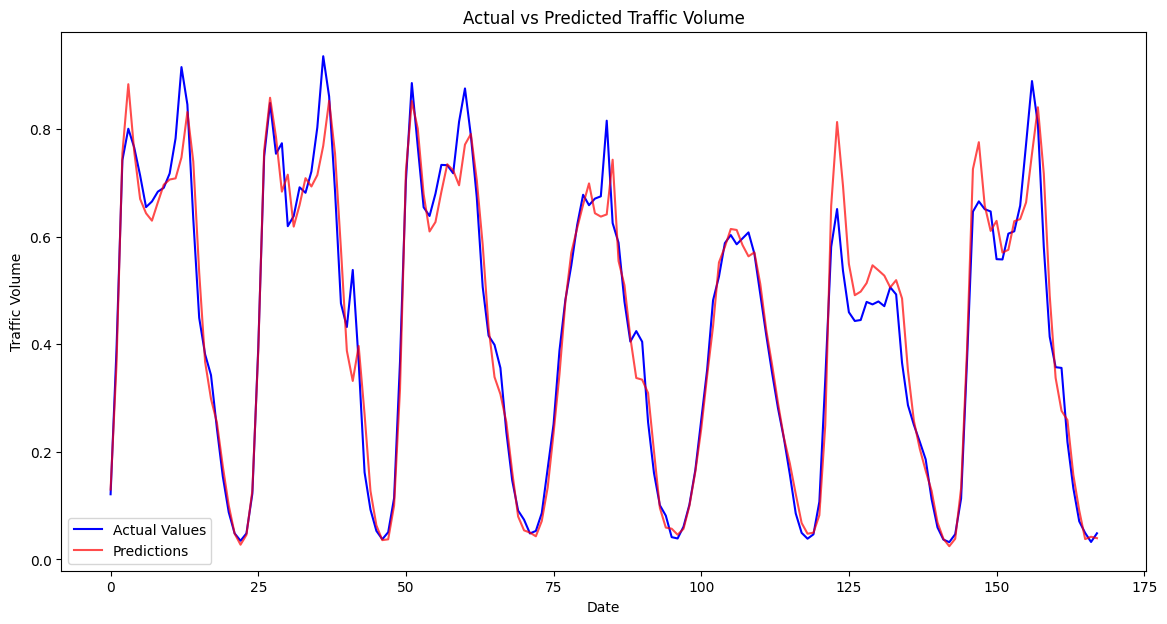

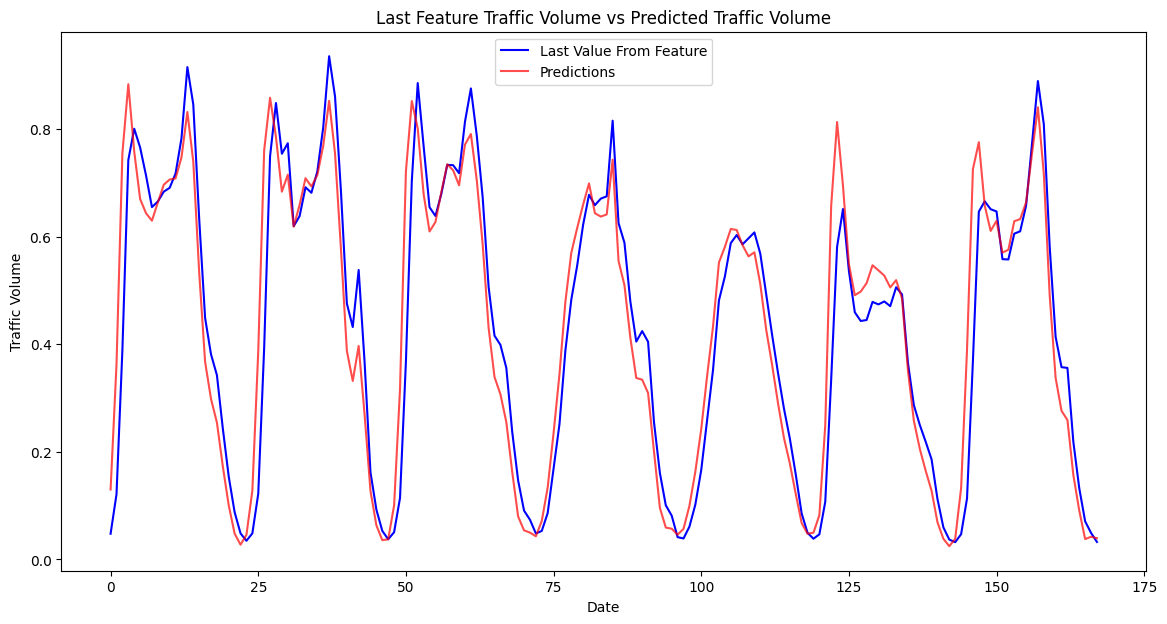

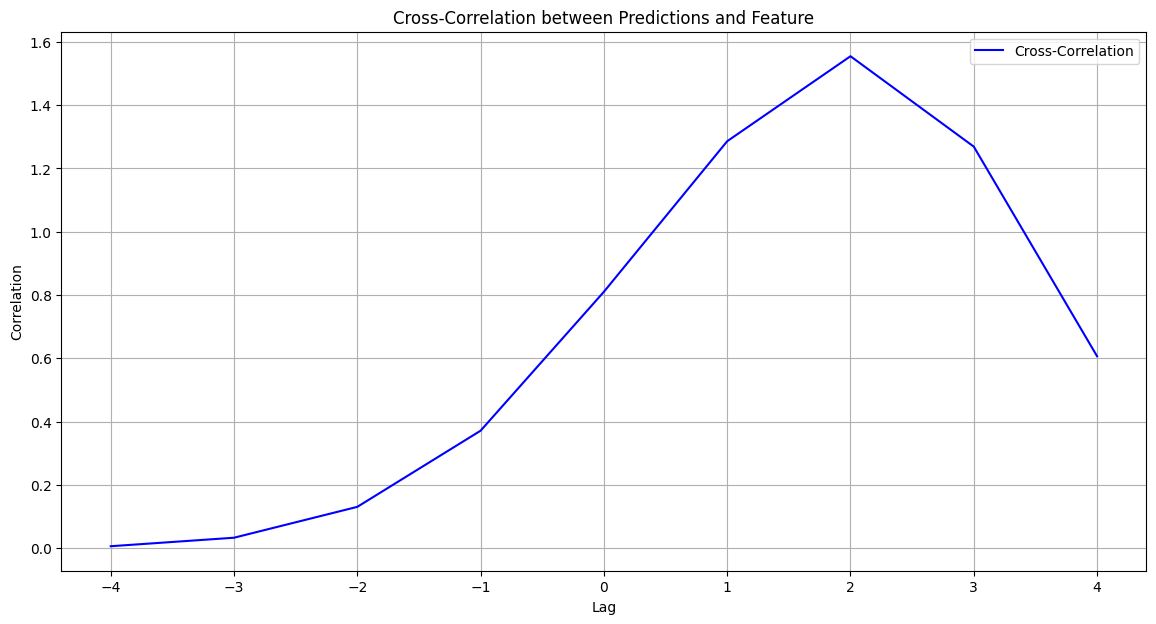

In [29]:
if not CLASSIFICATION:
    start = 200
    end = start + 24*7

    # plot actual vs predicted traffic volume
    plt.figure(figsize=(14, 7))
    plt.plot(y_test[start:end], label='Actual Values', color='b')
    plt.plot(test_preds[start:end], label='Predictions', color='r', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Traffic Volume')
    plt.title('Actual vs Predicted Traffic Volume')
    plt.legend()
    plt.show()

    # plot last feature vs predicted traffic volume
    plt.figure(figsize=(14, 7))
    plt.plot(X_test[start:end, -1, 0], label='Last Value From Feature', color='b')
    plt.plot(test_preds[start:end], label='Predictions', color='r', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Traffic Volume')
    plt.title('Last Feature Traffic Volume vs Predicted Traffic Volume')
    plt.legend()
    plt.show()



    # calculate cross-correlation
    def cross_correlation(x, y):
        correlation = torch.nn.functional.conv1d(
            x.unsqueeze(0).unsqueeze(0), 
            y.flip(0).unsqueeze(0).unsqueeze(0),
            padding=x.size(0) - 1
        ).squeeze().numpy()
        lags = np.arange(-(x.size(0) - 1), x.size(0))
        return correlation, lags

    correlation, lags = cross_correlation(test_preds[start:start+5].flatten(), X_test[start:start+5, -1, 0])

    # plot cross-correlation
    plt.figure(figsize=(14, 7))
    plt.plot(lags, correlation, label='Cross-Correlation', color='b')
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.title('Cross-Correlation between Predictions and Feature')
    plt.legend()
    plt.grid(True)
    plt.show()

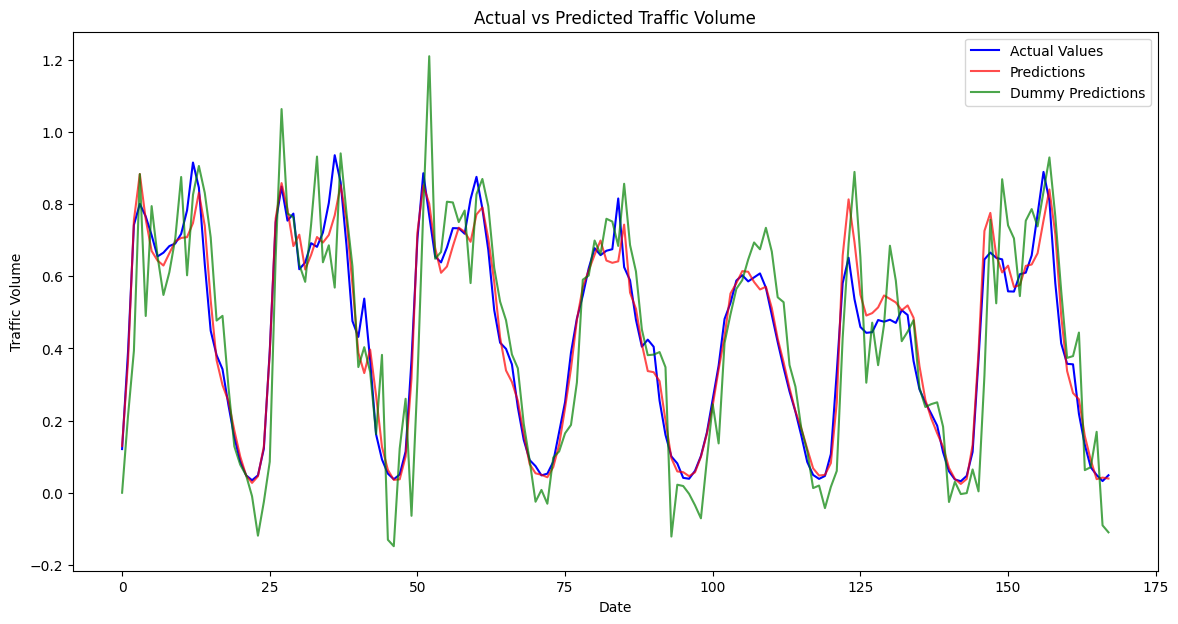

In [30]:
# plot actual vs dummy preds vs predicted traffic volume
# plot actual vs predicted traffic volume
plt.figure(figsize=(14, 7))
plt.plot(y_test[start:end], label='Actual Values', color='b')
plt.plot(test_preds[start:end], label='Predictions', color='r', alpha=0.7)
plt.plot(dummy_preds[start:end], label='Dummy Predictions', color='g', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.legend()
plt.show()